<a href="https://colab.research.google.com/github/ChennaChaitanya/Deepfake-videos/blob/main/chaitanya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tarfile
import os

# Path to your tar file in Google Drive
tar_path = '/content/drive/MyDrive/test.tar'
extract_path = '/content/deepfake_data'

# Extract
with tarfile.open(tar_path) as tar:
    tar.extractall(path=extract_path)

# Check the contents
print(os.listdir(extract_path))  # Should print: ['real', 'fake']


['fake_frames', 'fake', 'real_frames', 'real']


In [ ]:
import os

# Inspect 'fake' folder
fake_files = os.listdir('/content/deepfake_data/fake')
print("📁 FAKE folder sample files:", fake_files[:5])
print("Total files in FAKE:", len(fake_files))

# Inspect 'real' folder
real_files = os.listdir('/content/deepfake_data/real')
print("\n📁 REAL folder sample files:", real_files[:5])
print("Total files in REAL:", len(real_files))


📁 FAKE folder sample files: ['14_18__walking_outside_cafe_disgusted__6SB2BR0A.mp4', '23_24__talking_angry_couch__YR5OVD4S.mp4', '21_04__kitchen_pan__PRCQUMY8.mp4', '26_14__kitchen_still__ILLP29ZH.mp4', '18_09__walking_down_street_outside_angry__3VP8836C.mp4']
Total files in FAKE: 150

📁 REAL folder sample files: ['07__talking_angry_couch.mp4', '02__talking_angry_couch.mp4', '10__talking_against_wall.mp4', '15__talking_against_wall.mp4', '17__outside_talking_pan_laughing.mp4']
Total files in REAL: 55


In [ ]:
import cv2
import os

def extract_all_videos(input_folder, output_folder, label, every_n_frames=30):
    os.makedirs(output_folder, exist_ok=True)
    video_files = [f for f in os.listdir(input_folder) if f.endswith('.mp4')]

    print(f"📹 Found {len(video_files)} videos in {input_folder}")
    total_saved = 0

    for video in video_files:
        video_path = os.path.join(input_folder, video)
        cap = cv2.VideoCapture(video_path)
        frame_count = 0
        saved = 0

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if frame_count % every_n_frames == 0:
                frame_path = os.path.join(output_folder, f"{label}_{total_saved}.jpg")
                cv2.imwrite(frame_path, frame)
                saved += 1
                total_saved += 1
            frame_count += 1

        cap.release()
        print(f"✅ Extracted {saved} frames from {video}")

    print(f"🎉 Total frames saved in {output_folder}: {total_saved}")


In [ ]:
extract_all_videos('/content/deepfake_data/fake', '/content/deepfake_data/fake_frames', 'fake')
extract_all_videos('/content/deepfake_data/real', '/content/deepfake_data/real_frames', 'real')


📹 Found 150 videos in /content/deepfake_data/fake
✅ Extracted 24 frames from 14_18__walking_outside_cafe_disgusted__6SB2BR0A.mp4
✅ Extracted 39 frames from 23_24__talking_angry_couch__YR5OVD4S.mp4
✅ Extracted 22 frames from 21_04__kitchen_pan__PRCQUMY8.mp4
✅ Extracted 29 frames from 26_14__kitchen_still__ILLP29ZH.mp4
✅ Extracted 19 frames from 18_09__walking_down_street_outside_angry__3VP8836C.mp4
✅ Extracted 29 frames from 09_02__outside_talking_still_laughing__9TDCEK1Q.mp4
✅ Extracted 12 frames from 18_03__walk_down_hall_angry__22UBC0BS.mp4
✅ Extracted 49 frames from 01_20__talking_angry_couch__FW94AIMJ.mp4
✅ Extracted 40 frames from 06_03__talking_angry_couch__83ABVHC3.mp4
✅ Extracted 24 frames from 12_04__kitchen_still__96TQKDFJ.mp4
✅ Extracted 29 frames from 19_24__outside_talking_still_laughing__NPZW2Z9L.mp4
✅ Extracted 33 frames from 20_15__secret_conversation__99NHTFBM.mp4
✅ Extracted 37 frames from 03_14__walking_and_outside_surprised__H0VQHGS3.mp4
✅ Extracted 53 frames from 2

In [ ]:
!mkdir -p /content/deepfake_images/real
!mkdir -p /content/deepfake_images/fake

# Move the extracted frames into the right folders
!mv /content/deepfake_data/real_frames/* /content/deepfake_images/real/
!mv /content/deepfake_data/fake_frames/* /content/deepfake_images/fake/


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    '/content/deepfake_images',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    '/content/deepfake_images',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)


Found 4329 images belonging to 2 classes.
Found 1081 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D # Import layers used for building the custom classification head
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# 📌 Train Model
history = model.fit(train_gen, validation_data=val_gen, epochs=10)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 452s 3s/step - accuracy: 0.6115 - loss: 0.7043 - val_accuracy: 0.7105 - val_loss: 0.6458
Epoch 2/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 370s 3s/step - accuracy: 0.7014 - loss: 0.5690 - val_accuracy: 0.7160 - val_loss: 0.6499
Epoch 3/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 391s 3s/step - accuracy: 0.7455 - loss: 0.4884 - val_accuracy: 0.7234 - val_loss: 0.6582
Epoch 4/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 453s 3s/step - accuracy: 0.7771 - loss: 0.4591 - val_accuracy: 0.7114 - val_loss: 0.6581
Epoch 5/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 373s 3s/step - accuracy: 0.8009 - loss: 0.4298 - val_accuracy: 0.7188 - val_loss: 0.7026
Epoch 6/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 399s 3s/step - accuracy: 0.8078 - loss: 0.3905 - val_accuracy: 0.7253 - val_loss: 0.6942
Epoch 7/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 444s 3s/step - accuracy: 0.8399 - loss: 0.3622 - val_accuracy: 0.7105 - val_loss: 0.7218
Epoch 8/10
136/136 ━━━━━━━━━━━━━━━━━━━━ 370s 3s/step - accuracy: 0.8415 - loss: 0.3543 - val_accu

In [ ]:
# 📌 Fine-tune top 50 layers for better accuracy
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
history_finetune = model.fit(train_gen, validation_data=val_gen, epochs=5)


Epoch 1/5
136/136 ━━━━━━━━━━━━━━━━━━━━ 607s 4s/step - accuracy: 0.7613 - loss: 0.4897 - val_accuracy: 0.7021 - val_loss: 0.8580
Epoch 2/5
136/136 ━━━━━━━━━━━━━━━━━━━━ 530s 4s/step - accuracy: 0.8380 - loss: 0.3584 - val_accuracy: 0.7040 - val_loss: 0.9544
Epoch 3/5
136/136 ━━━━━━━━━━━━━━━━━━━━ 518s 4s/step - accuracy: 0.8638 - loss: 0.2955 - val_accuracy: 0.7021 - val_loss: 0.9975
Epoch 4/5
136/136 ━━━━━━━━━━━━━━━━━━━━ 524s 4s/step - accuracy: 0.8853 - loss: 0.2592 - val_accuracy: 0.7068 - val_loss: 1.0554
Epoch 5/5
136/136 ━━━━━━━━━━━━━━━━━━━━ 527s 4s/step - accuracy: 0.9051 - loss: 0.2188 - val_accuracy: 0.7077 - val_loss: 1.0795


In [ ]:
# 📌 Save Model
model.save('/content/deepfake_model.keras')


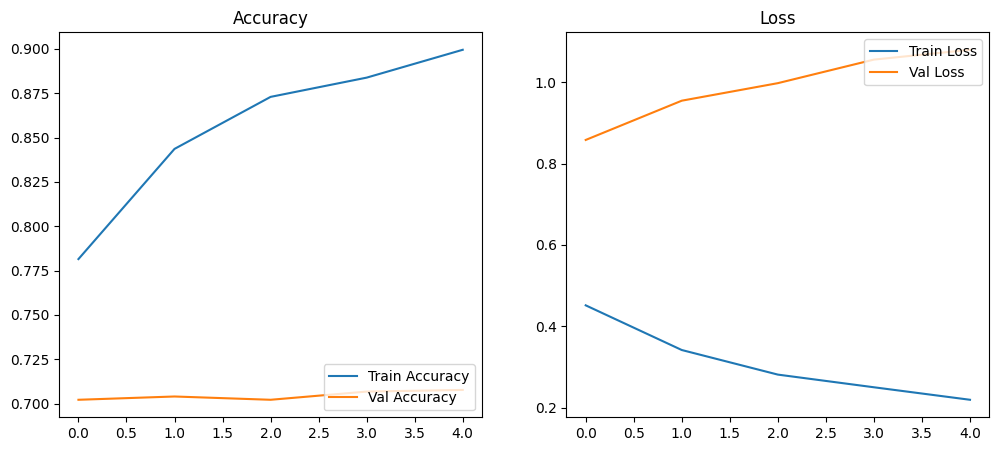

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Plot accuracy & loss
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')

    plt.show()

plot_history(history_finetune)


34/34 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step


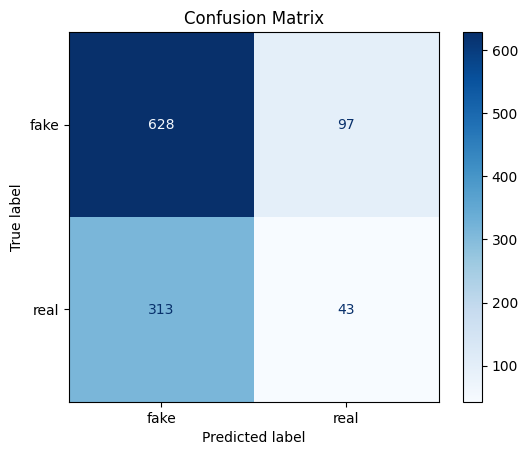

In [ ]:
# Get predictions and true labels
val_gen.reset()
preds = model.predict(val_gen, verbose=1)
pred_labels = (preds > 0.5).astype(int)
true_labels = val_gen.classes

# Plot confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_gen.class_indices)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
final_train_acc = history_finetune.history['accuracy'][-1] * 100
final_val_acc = history_finetune.history['val_accuracy'][-1] * 100

print(f"✅ Final Training Accuracy: {final_train_acc:.2f}%")
print(f"✅ Final Validation Accuracy: {final_val_acc:.2f}%")


✅ Final Training Accuracy: 89.95%
✅ Final Validation Accuracy: 70.77%


In [ ]:
# 📊 Evaluate final accuracy on validation set
loss, accuracy = model.evaluate(val_gen)
print(f"\n🎯 Final Validation Accuracy: {accuracy * 100:.2f}%")

34/34 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.7089 - loss: 1.0925

🎯 Final Validation Accuracy: 70.77%


In [ ]:
# Save everything in a project folder
project_dir = '/content/drive/MyDrive/deepfake_project'
!mkdir -p $project_dir

# Save model
model.save(f'{project_dir}/deepfake_model.keras')

# Save label map for prediction decoding
import json
with open(f'{project_dir}/label_map.json', 'w') as f:
    json.dump(val_gen.class_indices, f)

# Save prediction script
with open(f'{project_dir}/predict_script.py', 'w') as f:
    f.write("""
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def extract_face(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
    if len(faces) == 0:
        return None
    x, y, w, h = sorted(faces, key=lambda x: x[2]*x[3], reverse=True)[0]
    return frame[y:y+h, x:x+w]

def predict_deepfake_on_video(video_path, model_path, every_n_frames=30):
    model = load_model(model_path)
    cap = cv2.VideoCapture(video_path)
    frame_num = 0
    predictions = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_num % every_n_frames == 0:
            face = extract_face(frame)
            if face is None:
                frame_num += 1
                continue
            img = cv2.resize(face, (224, 224))
            img = img_to_array(img)
            img = np.expand_dims(img, axis=0)
            img = img / 255.0
            prob = model.predict(img, verbose=0)[0][0]
            label = "FAKE" if prob > 0.5 else "REAL"
            print(f"🖼 Frame {frame_num}: {label} ({prob:.2f})")
            predictions.append(label)

        frame_num += 1

    cap.release()
    return predictions
""")


In [ ]:
# Load saved model and script
from google.colab import drive
drive.mount('/content/drive')

project_dir = '/content/drive/MyDrive/deepfake_project'
model_path = f'{project_dir}/deepfake_model.keras'

# Upload video
from google.colab import files
uploaded = files.upload()
import os
video_path = os.path.join('/content', next(iter(uploaded)))

# Load prediction function
exec(open(f'{project_dir}/predict_script.py').read())

# Run prediction
results = predict_deepfake_on_video(video_path, model_path)
from collections import Counter
counts = Counter(results)
print("📊 Prediction Summary:", counts)

if counts['FAKE'] > counts['REAL']:
    print("❌ This video is likely a DEEPFAKE")
else:
    print("✅ This video is likely REAL")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving alia.mp4 to alia (1).mp4
🖼 Frame 30: FAKE (0.78)
🖼 Frame 90: FAKE (0.89)
🖼 Frame 180: FAKE (0.77)
🖼 Frame 210: FAKE (0.67)
🖼 Frame 240: FAKE (0.74)
🖼 Frame 270: FAKE (0.66)
🖼 Frame 300: FAKE (0.57)
🖼 Frame 330: REAL (0.05)
🖼 Frame 390: FAKE (0.85)
📊 Prediction Summary: Counter({'FAKE': 8, 'REAL': 1})
❌ This video is likely a DEEPFAKE
